In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)
# Change this based on the drive being used

my_voice_data_no_spaces = '/content/drive/MyDrive/Study_materials/Voice disorder detection project/patients'
my_voice_data = '/content/drive/MyDrive/Study_materials/Voice\ disorder\ detection\ project/patients'

Mounted at /content/drive


imports and installations


In [2]:
# install google's VAD
# !pip install webrtcvad

#install librosa and sox
!apt-get install libsox-fmt-all
!apt-get install sox
!pip install sox
!pip install dill


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-all
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse
  libsox3 libwavpack1
0 upgraded, 15 newly installed, 0 to remove and 45 not upgraded.
Need to get 696 kB of archives.
After this operation, 2,333 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao4 amd64 1.2.2+2018

In [3]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 36.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.19.2 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib 0.4.6 which is incompatible.
tensorflow-datasets 4.9.4 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires pro

In [4]:

## Imports

import os
import glob
import numpy as np
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from IPython.display import Audio
import pandas as pd
from scipy.io import wavfile
import re
import dill
from sox.file_info import sample_rate
import tensorflow as tf
import tensorflow_hub as hub
import csv


import sox

print(torch.__version__)
print(torchaudio.__version__)

## Use cuda if available
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.2.1+cu121
2.2.1+cu121
cpu


In [5]:
# Reload the file
load = '/content/drive/MyDrive/Study_materials/Voice disorder detection project/patients_df_2024-04-04.pickle'
df_reloaded = dill.load(open(load, "rb"))
list_of_diseases = ['scar',
 'polyp',
 'paresis',
 'dysplasia',
 'paralysis',
 'anterior web',
 'MTD',
 'atrophy',
 'cyst',
 'chronic laryngitis',
 'none',
 'laryngeal tremor',
 'bilateral phonotraumatic lesions',
 'ectasia',
 'sulcus',
 'granuloma',
 'leukoplakia',
 "Reinke's edema",
 'Spasmodic dysphonia',
 'carcinoma',
 'vocal fold atrophy',
 'papillomatosis',
 'presbyphonia',
 'glottic gap',
 'glottic insufficiency',
 'lichen planus',
 'unilateral photraumatic lesion',
 'laryngitis']

Example on how to access data

In [ ]:
# Accessing patient 2, index 0 recording ( low pitch E)

# patient_num - Patient's number
# chunk_num - patient's audio chunk number (chronological)
# sample_rate - chunk's sample rate
# date - The chunk's recording data - np array
df_reloaded.iloc[2,:]

In [7]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

Loading YAMNet from TensorFlow Hub

We are going to use a pre-trained YAMNet from Tensorflow Hub to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the load function.

In [8]:
# Load the model.
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [9]:
yamnet_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7cfa4b7cf610>

# TODO
Change to multi-label classification:

Diagnosis column needs to be a multi-hot vector, as in a single patient can have multiple diseases.

Training needs to accomdate for that change
(can be problematic with Yamnet)

In [ ]:
my_classes = ['Healthy', 'Ill']
map_class_to_id = {'Healthy':0, 'Ill':1}
# Create a deep copy

df_reloaded_binary_classification = df_reloaded.copy()
df_reloaded_binary_classification['Diagnosis'] = df_reloaded_binary_classification['Diagnosis'].apply(lambda x: 0 if x == ['none'] else 1)

In [ ]:
#Replace chunk objects in pandas series with their object.data
audio_LPE_col = df_reloaded_binary_classification['low pitch E'][1::].apply(lambda x: x.data if x != None else None).to_numpy()
audio_LPE_col.shape

(238,)

In [ ]:
targets = df_reloaded_binary_classification['Diagnosis'][1::].to_numpy()
targets.shape

(238,)

# **From this point on, i'm using the original recordings pathways, and ignoring the preprocessed data**

In [ ]:
# Create df with file pathways and labels as columns
num_of_patients_recorded = 238
pathway_lists = [None] * (num_of_patients_recorded+1)
my_voice_data_no_spaces = '/content/drive/MyDrive/Study_materials/Voice disorder detection project/patients'
for file in glob.glob(my_voice_data_no_spaces + "/*.wav"):
    pat_num_str = re.findall(r'\d+', file)[0]
    if( int(pat_num_str) <= num_of_patients_recorded):
      # print(f'------------ Working on patient {pat_num_str} -------------- ')
      pathway_lists[int(pat_num_str)] = str(file)
    # else:
    #   print("Patient is not on the excel table")

In [ ]:


df = pd.DataFrame({'filepathway': pathway_lists})
df['label'] = df_reloaded_binary_classification['Diagnosis']
# prompt: drop row 0 from df

df = df.drop(0)
# prompt: cast df label column to integers

df['label'] = df['label'].astype(int)
df

In [ ]:
# prompt: create a vector of uniform random integer from 1-5, the same size of df

random_uniform = np.random.randint(low=1, high=6, size=len(df))
df['fold'] = random_uniform.astype(int)
df

,filepathway,label,fold
1,/content/drive/MyDrive/Study_materials/Voice d...,1,4
2,/content/drive/MyDrive/Study_materials/Voice d...,1,3
3,/content/drive/MyDrive/Study_materials/Voice d...,1,1
4,/content/drive/MyDrive/Study_materials/Voice d...,1,5
5,/content/drive/MyDrive/Study_materials/Voice d...,1,5
...,...,...,...
234,/content/drive/MyDrive/Study_materials/Voice d...,0,2
235,/content/drive/MyDrive/Study_materials/Voice d...,0,5
236,/content/drive/MyDrive/Study_materials/Voice d...,0,5
237,/content/drive/MyDrive/Study_materials/Voice d...,0,1


In [ ]:
filenames = df['filepathway']
targets = df['label']
folds = df['fold']


main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets,folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec


(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu',name = 'Relu'),
    tf.keras.layers.Dense(len(my_classes), name = 'Binary_classification')
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Relu (Dense)                (None, 512)               524800    
                                                                 
 Binary_classification (Dens  (None, 2)                1026      
 e)                                                              
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


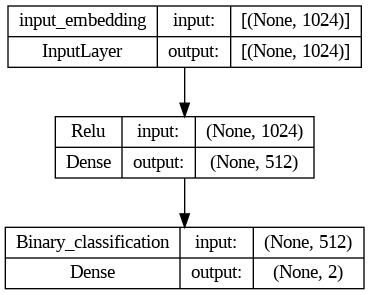

In [ ]:
tf.keras.utils.plot_model(my_model, show_shapes=True)

In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=25,
                       validation_data=val_ds,
                       callbacks=callback)

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

179/179 [==============================] - 1s 5ms/step - loss: 1.6589 - accuracy: 0.5667
Loss:  1.6588973999023438
Accuracy:  0.5666608214378357


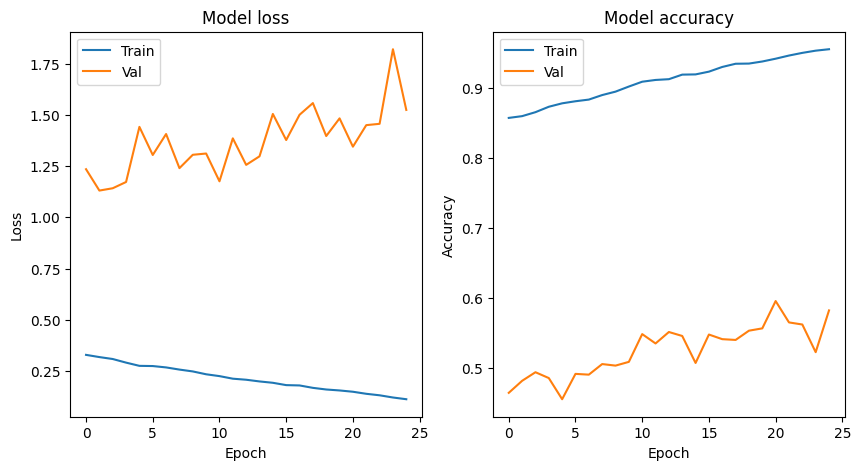

In [ ]:
# prompt: plot two plots together side by side
def plot_loss_and_accuracy(history):
  try:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Val'], loc='upper left')
    axes[1].plot(history.history['accuracy'])
    axes[1].plot(history.history['val_accuracy'])
    axes[1].set_title('Model accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Val'], loc='upper left')
    plt.show()
  except:
    print("Something went wrong with plotting loss/accuracy progress")

plot_loss_and_accuracy(history)